In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget http://data.celltrackingchallenge.net/training-datasets/Fluo-C2DL-MSC.zip
!jar xvf Fluo-C2DL-MSC.zip

In [ ]:
import os
import PIL
from PIL import ImageOps
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import cv2

img_size = (160, 160)
num_classes = 2
batch_size = 32

input_dir = "/content/drive/MyDrive/Image for ML/Original"
target_dir="/content/drive/MyDrive/Image for ML/SEG"

input_img_paths = sorted(
    [
     os.path.join(input_dir,fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".tif")
    ]
)

target_img_paths = sorted(
    [
     os.path.join(target_dir,fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".tif") and not fname.startswith(".")
    ]
)

print("Number of samples:",len(input_img_paths))
for input_path, target_path in zip(input_img_paths[:20], target_img_paths[:20]):
  print(input_path, "|", target_path)




Number of samples: 893
/content/drive/MyDrive/Image for ML/Original/C1-000.tif | /content/drive/MyDrive/Image for ML/SEG/C1-000.tif
/content/drive/MyDrive/Image for ML/Original/C1-001.tif | /content/drive/MyDrive/Image for ML/SEG/C1-001.tif
/content/drive/MyDrive/Image for ML/Original/C1-002.tif | /content/drive/MyDrive/Image for ML/SEG/C1-002.tif
/content/drive/MyDrive/Image for ML/Original/C1-003.tif | /content/drive/MyDrive/Image for ML/SEG/C1-003.tif
/content/drive/MyDrive/Image for ML/Original/C1-004.tif | /content/drive/MyDrive/Image for ML/SEG/C1-004.tif
/content/drive/MyDrive/Image for ML/Original/C1-005.tif | /content/drive/MyDrive/Image for ML/SEG/C1-005.tif
/content/drive/MyDrive/Image for ML/Original/C1-006.tif | /content/drive/MyDrive/Image for ML/SEG/C1-006.tif
/content/drive/MyDrive/Image for ML/Original/C1-007.tif | /content/drive/MyDrive/Image for ML/SEG/C1-007.tif
/content/drive/MyDrive/Image for ML/Original/C1-008.tif | /content/drive/MyDrive/Image for ML/SEG/C1-008.

In [ ]:
name=target_img_paths[100].split('/')[-1]
filename= "/content/drive/MyDrive/Image for ML/BWSEG/%s" %name
print(filename)

/content/drive/MyDrive/Image for ML/BWSEG/C10-052.tif


In [ ]:
img = Image.open(target_img_paths[1])
imarray = np.array(img)
im_bw = imarray > 0
data = Image.fromarray(im_bw,mode='L')
data.save('test.tif')

In [ ]:
for j, path in enumerate(target_img_paths):
  img = Image.open(path)
  imarray = np.array(img)
  im_bw = imarray > 0
  data = Image.fromarray(im_bw,mode='L')
  savename = path.split('/')[-1]
  filename= "/content/drive/MyDrive/Image for ML/BWSEG/%s" %savename
  data.save(filename)
  #plt.imsave('filename.png', np.array(data).reshape(50,50), cmap=cm.gray)



In [ ]:
input_img_paths[19]
target_img_paths[19]

'/content/drive/MyDrive/Image for ML/BWSEG/C1-019.tif'

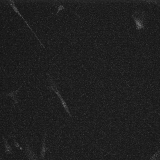

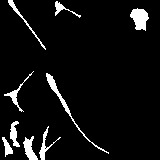

In [ ]:
target_dir="/content/drive/MyDrive/Image for ML/BWSEG"
target_img_paths = sorted(
    [
     os.path.join(target_dir,fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".tif") and not fname.startswith(".")
    ]
)

im=load_img(input_img_paths[19],target_size=img_size,color_mode="grayscale")
display(im)

img=ImageOps.autocontrast(load_img(target_img_paths[19],target_size=img_size,color_mode="grayscale"))
display(img)

In [ ]:
test=np.array(img)
test.shape

(832, 992)

In [ ]:
num_classes = 2

In [ ]:
# residual convolutional block

def r_Conv(input_layer,out_filter_n,batch_normalization=True,kernel_size = [3,3],stride=[1,1], padding = 'same',stack_n = 2):
  
  input_filters_n = input_layer.get_shape().as_list()[1]
  
  input = input_layer
  for i in range(stack_n):
    layer = layers.Conv2D(out_filter_n//4,[1,1],strides = stride, padding =padding)(input)
    if batch_normalization:
      layer = layers.BatchNormalization()(layer)
    layer = layers.Activation('relu')(layer)

    layer = layers.Conv2D(out_filter_n//4, kernel_size,strides=stride,padding = padding)(layer)
    layer = layers.Conv2D(out_filter_n, [1,1],strides=stride,padding = padding)(layer)
  
  if out_filter_n != input_filters_n:
    skip_layer = layers.Conv2D(out_filter_n,[1,1],strides = stride,padding=padding)(input_layer)
  else:
    skip_layer = input_layer

  out_layer = layers.add([layer, skip_layer])
  return out_layer



In [ ]:
#  recurrent residual block
def rr_conv_block(input_layer,out_filter_n,batch_normalization=True,kernel_size = [3,3],stride=[1,1], padding = 'same',stack_n=2,recurrent_n = 2):
  input_filters_n = input_layer.get_shape().as_list()[1]
  
  input = input_layer
  
  if out_filter_n != input_filters_n:
    skip_layer = layers.Conv2D(out_filter_n,[1,1],strides = stride,padding=padding)(input_layer)
  else:
    skip_layer = input_layer

  layer = skip_layer
  for j in range(stack_n):
    for i in range(recurrent_n):
      layer1 = layers.Conv2D(out_filter_n//4,[1,1],strides = stride, padding =padding)(layer)
      if batch_normalization:
        layer1 = layers.BatchNormalization()(layer1)
      layer1 = layers.Activation('relu')(layer1)

      layer1 = layers.Conv2D(out_filter_n//4, kernel_size,strides=stride,padding = padding)(layer1)
      layer1 = layers.Conv2D(out_filter_n, [1,1],strides=stride,padding = padding)(layer1)
    layer = layer1
  
  out_layer = layers.add([layer1, skip_layer])
  return out_layer

In [ ]:
# attention block

def att_block(x, g, inter_n):

  theta_x = layers.Conv2D(inter_n,[1,1],strides = [1,1])(x)
  phi_x = layers.Conv2D(inter_n,[1,1],strides = [1,1])(g)

  act = layers.Activation('relu')(layers.add([theta_x,phi_x]))

  psi = layers.Conv2D(1,[1,1],strides = [1,1])(act)

  rate = layers.Activation('sigmoid')(psi)

  att_output = layers.multiply([x,rate])

  return att_output


In [ ]:
# attention and concate

def att_up_concate(down_layer,skip_layer):
  
  in_channel = down_layer.get_shape().as_list()[1]
  up = layers.UpSampling2D(size=(2,2))(down_layer)

  layer = att_block(x=skip_layer,g=up,inter_n = in_channel//4)

  att_output=layers.Concatenate(axis=3)([up,layer])

  return att_output

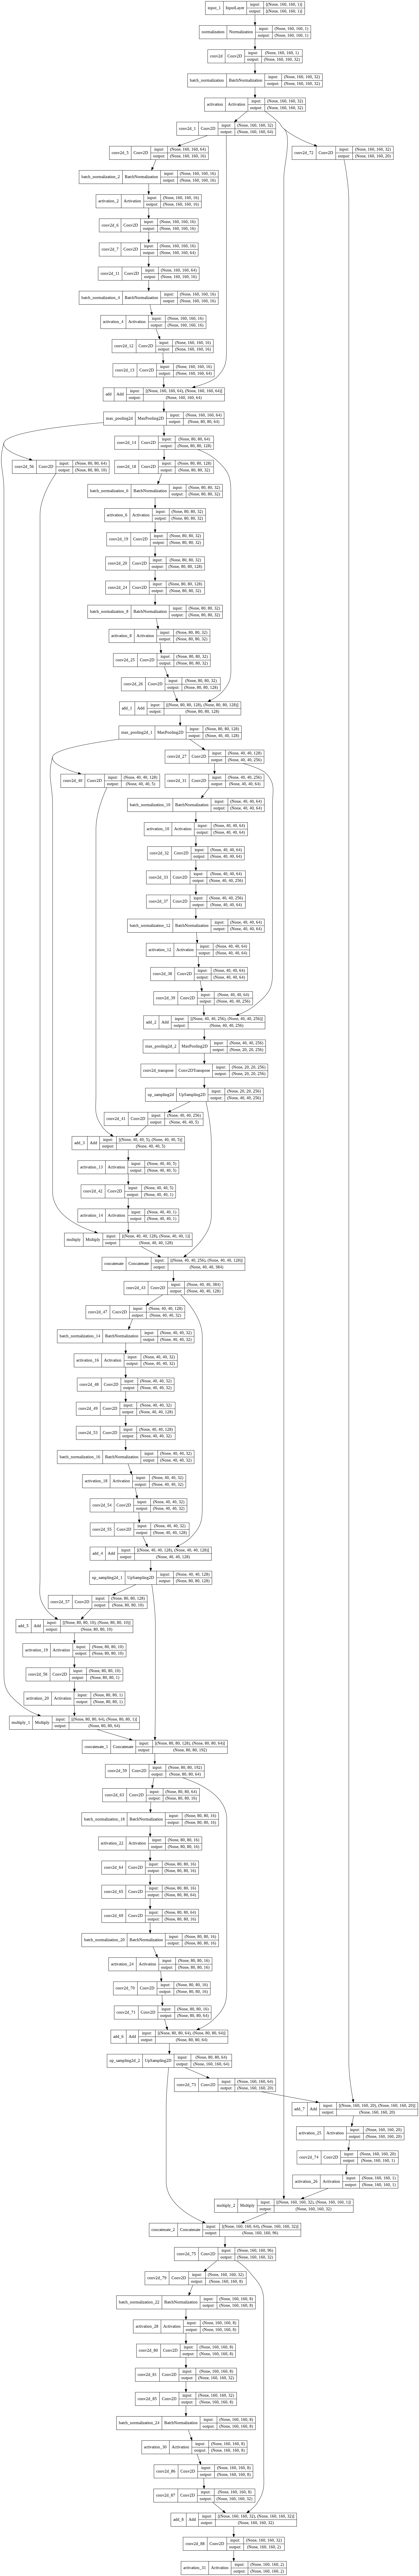

In [ ]:
def att_rr_unet(img_w,img_h,n_label):

  depth =4
  features = 64
  skips = []
  inputs= keras.Input(shape=img_size+(1,))

  x=layers.Normalization(axis=None)(inputs)

  x=layers.Conv2D(32,3,strides=1,padding="same")(x)

  x=layers.BatchNormalization()(x)
  x=layers.Activation("relu")(x)
  skips.append(x)

  previous_block_activation = x

  for filters in [64,128,256]:
    x = rr_conv_block(x,filters)
    
    x=layers.MaxPooling2D((2,2))(x)
    skips.append(x)

  j=2

  x = layers.Conv2DTranspose(filters,3,padding="same")(x)

  for filters in [128,64,32]:

    x= att_up_concate(x,skips[j])
    x= rr_conv_block(x,filters)
    j=j-1

  outputs=layers.Conv2D(n_label,(1,1),padding="same")(x)
  #outputs=layers.Conv2D(num_classes,3,activation="softmax",padding="same")(x)

  outputs= layers.Activation('sigmoid')(outputs)

  model=keras.Model(inputs,outputs)
  return model

keras.backend.clear_session()

model=att_rr_unet(img_size[0],img_size[1],num_classes)
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 160, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
class CellImage(keras.utils.Sequence):
  def __init__(self,batch_size,img_size,input_paths,target_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.input_img_paths = input_paths
    self.target_img_paths = target_paths

  def __len__(self):
    return len(self.target_img_paths)//self.batch_size
  
  def __getitem__(self, idx):
    i =idx*self.batch_size
    batch_input_img_paths = self.input_img_paths[i:i+self.batch_size]
    batch_target_img_paths = self.target_img_paths[i:i+self.batch_size]
    x=np.zeros((self.batch_size,)+self.img_size+(1,),dtype="uint8")

    #print(self.input_img_paths[i:i+10])
    #print(self.target_img_paths[i:i+10])

    for j, path in enumerate(batch_input_img_paths):
      img=load_img(path,target_size=self.img_size,color_mode="grayscale")
      x[j]=np.expand_dims(img,2)

    y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
    for j, path in enumerate(batch_target_img_paths):
      img=load_img(path,target_size=self.img_size,color_mode="grayscale")
      y[j]=np.expand_dims(img,2)

    return x,y

In [ ]:
import random


random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

In [ ]:
len(val_input_img_paths)


64

In [ ]:
val_sample_n = 64
train_input_img_paths=input_img_paths[:-val_sample_n]
train_target_img_paths=target_img_paths[:-val_sample_n]

val_input_img_paths=input_img_paths[-val_sample_n:]
val_target_img_paths=target_img_paths[-val_sample_n:]

In [ ]:
for i in range(64):
  print(val_input_img_paths[i],"|",val_target_img_paths[i])

/content/drive/MyDrive/Image for ML/Original/C8-075.tif | /content/drive/MyDrive/Image for ML/BWSEG/C8-075.tif
/content/drive/MyDrive/Image for ML/Original/C6-081.tif | /content/drive/MyDrive/Image for ML/BWSEG/C6-081.tif
/content/drive/MyDrive/Image for ML/Original/C7-008.tif | /content/drive/MyDrive/Image for ML/BWSEG/C7-008.tif
/content/drive/MyDrive/Image for ML/Original/C6-028.tif | /content/drive/MyDrive/Image for ML/BWSEG/C6-028.tif
/content/drive/MyDrive/Image for ML/Original/C7-028.tif | /content/drive/MyDrive/Image for ML/BWSEG/C7-028.tif
/content/drive/MyDrive/Image for ML/Original/C10-020.tif | /content/drive/MyDrive/Image for ML/BWSEG/C10-020.tif
/content/drive/MyDrive/Image for ML/Original/C6-050.tif | /content/drive/MyDrive/Image for ML/BWSEG/C6-050.tif
/content/drive/MyDrive/Image for ML/Original/C3-025.tif | /content/drive/MyDrive/Image for ML/BWSEG/C3-025.tif
/content/drive/MyDrive/Image for ML/Original/C9-014.tif | /content/drive/MyDrive/Image for ML/BWSEG/C9-014.tif

In [ ]:
batch_size = 32

train_gen = CellImage(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)

val_gen = CellImage(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

In [ ]:

x,y=val_gen.__getitem__(1)

In [ ]:
y.shape

(32, 160, 160, 1)

In [ ]:
img = Image.fromarray(x[1,:,:,0])


In [ ]:
img.save('my2.tif')

In [ ]:
#initial_learning_rate = 0.0001
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
#)


model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(),
    #optimizer=keras.optimizers.Adam(learning_rate=0.001,clipvalue=0.5),
    metrics=["acc"],
)

callbacks=[keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Image for ML/att_rr_unet_segmentaion.h5",save_best_only=True)]
epochs=15

train_history=model.fit(train_gen,epochs=epochs,validation_data=val_gen,callbacks=callbacks)


Epoch 1/15
25/25 [==============================] - ETA: 0s - loss: 0.8907 - acc: 0.8363

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


25/25 [==============================] - 28s 909ms/step - loss: 0.8907 - acc: 0.8363 - val_loss: 2.3031 - val_acc: 0.0590
Epoch 2/15
25/25 [==============================] - 22s 854ms/step - loss: 0.2295 - acc: 0.8667 - val_loss: 0.5867 - val_acc: 0.6226
Epoch 3/15
25/25 [==============================] - 22s 844ms/step - loss: 0.1939 - acc: 0.8577 - val_loss: 0.2677 - val_acc: 0.7911
Epoch 4/15
25/25 [==============================] - 22s 855ms/step - loss: 0.1780 - acc: 0.8501 - val_loss: 0.2624 - val_acc: 0.9149
Epoch 5/15
25/25 [==============================] - 22s 854ms/step - loss: 0.1684 - acc: 0.8488 - val_loss: 0.2255 - val_acc: 0.8764
Epoch 6/15
25/25 [==============================] - 21s 807ms/step - loss: 0.1586 - acc: 0.8456 - val_loss: 0.2394 - val_acc: 0.9110
Epoch 7/15
25/25 [==============================] - 21s 810ms/step - loss: 0.1500 - acc: 0.8439 - val_loss: 0.2792 - val_acc: 0.9430
Epoch 8/15
25/25 [==============================] - 22s 851ms/step - loss: 0.147

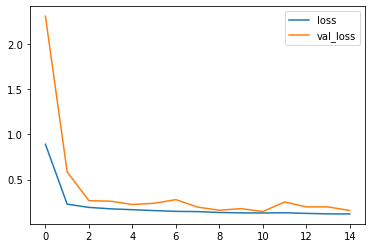

In [ ]:
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
modelbest = att_rr_unet(img_size[0],img_size[1],num_classes)
modelbest.load_weights('/content/drive/MyDrive/Image for ML/att_rr_unet_segmentaion.h5')


val_preds=modelbest.predict(val_gen)

In [ ]:
val_preds.shape

(64, 160, 160, 2)

In [ ]:
def displaymask(i):
  mask=np.argmax(val_preds[i],axis=-1)
  print(mask.shape)
  mask=np.expand_dims(mask,axis=-1)
  print(mask.shape)
  img=PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
  display(img)



In [ ]:
x,y=train_gen.__getitem__(1)

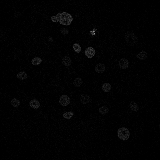

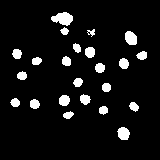

(160, 160)
(160, 160, 1)


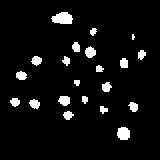

In [ ]:
i=11
im = load_img(val_input_img_paths[i],target_size=img_size,color_mode="grayscale")
display(im)
iml=ImageOps.autocontrast(load_img(val_target_img_paths[i],target_size=img_size,color_mode="grayscale"))
display(iml)
displaymask(i)

In [ ]:
val_preds[10].shape

(160, 160, 2)

In [ ]:
x = np.array([[1, 2],[2,3]])

In [ ]:
x

array([[1, 2],
       [2, 3]])

In [ ]:
y=np.expand_dims(x, axis=2)

In [ ]:
y.shape

(2, 2, 1)

In [ ]:
y-1

array([[[0],
        [1]],

       [[1],
        [2]]])